In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import false_discovery_control

In [2]:
nas_dir = "/home/jaejoong/cocoanlab02"
dat_dir = os.path.join(nas_dir, "projects/AIDA/dataset")
result_dir = os.path.join(nas_dir, "projects/AIDA/results")

In [3]:
all_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_df.csv"))
all_resp_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_resp_med42_df.csv"))

In [4]:
prev_mae = {"Test 1": {"Rosenman2024": 3.46,
                       "Agarwal2024": 3.52,
                       "Milintsevich2024": 3.59,
                       "Milintsevich2023": 3.78,
                       "Lau2023": 3.80},
            "Test 2 E-DAIC": {"Sadeghi2024": 3.86,
                              "Ray2019": 4.02,
                              "Sadeghi2023": 4.26}}
Q_desc = ["Q1: Anhedonia", # Diminished interest or pleasure
          "Q2: Depressed mood",
          "Q3: Sleep disturbance", # Insomnia or hypersomnia
          "Q4: Fatigue", # Fatigue or loss of energy
          "Q5: Appetite disturbance", # Poor appetite or overeating
          "Q6: Worthlessness", # Feelings of worthlessness or guilt
          "Q7: Poor concentration", # Diminished ability to think or concentrate
          "Q8: Psychomotor disturbance", # Psychomotor agitation or retardation
          "Q9: Positive sentiment",
          "Q10: Negative sentiment",
          "Q11: Self-focused language",
          "Q12: Present-focused language",
          "Q13: Emotion differentiation",
          "Q14: Mindreading",
          "Q15: Catastrophizing",
          "Q16: All-or-nothing thinking",
          "Q17: Emotional reasoning",
          "Q18: Labeling",
          "Q19: Mental filter",
          "Q20: Overgeneralization",
          "Q21: Personalization",
          "Q22: Should statements",
          "Q23: Disqualifying the positive"] # Minimizing or disqualifying the positive

In [5]:
def linreg_scaled(X, Y, wh_tr):

    scaler = StandardScaler()
    scaler.fit_transform(X[wh_tr, :])
    X_scaled = scaler.transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled[wh_tr, :], Y[wh_tr])
    Y_pred = model.predict(X_scaled)

    return scaler, model, Y_pred

def linreg_metrics(Y, Y_pred):
    
    mae = mean_absolute_error(Y, Y_pred)
    rmse = root_mean_squared_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    metrics = {"mae": mae, "rmse": rmse, "r2": r2}

    return metrics

In [6]:
all_mdl = {"Full": {"Q": range(0,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "PHQ8": {"Q": range(0,8), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "Ling": {"Q": range(8,13), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "CDS": {"Q": range(13,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "NonD": {"Q": range(23,33), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
           "Dir": {"Q": range(33,34), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}}}

for mdl in all_mdl:
    
    X = np.array(all_resp_df.iloc[:, all_mdl[mdl]["Q"]])
    Y = np.array(all_df["Depression_severity"])
    wh_tr = np.array(all_df["split"] == "Training")
    
    all_mdl[mdl]["scaler"], all_mdl[mdl]["model"], all_mdl[mdl]["Y_pred"] = linreg_scaled(X, Y, wh_tr)
    for split in ["Training", "Test 1", "Test 2", "Test 2 E-DAIC"]:
        wh_split = all_df["split_edaic" if split == "Test 2 E-DAIC" else "split"] == split
        all_mdl[mdl]["metrics"][split] = linreg_metrics(Y[wh_split], all_mdl[mdl]["Y_pred"][wh_split])

In [7]:
joblib.dump(all_mdl, os.path.join(result_dir, "all_mdl_med42.joblib"))

['/home/jaejoong/cocoanlab02/projects/AIDA/results/all_mdl_med42.joblib']

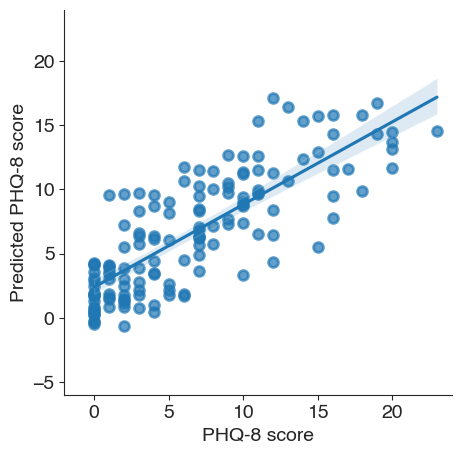

Training: MAE = 2.67, RMSE = 3.44, R2 = 0.64


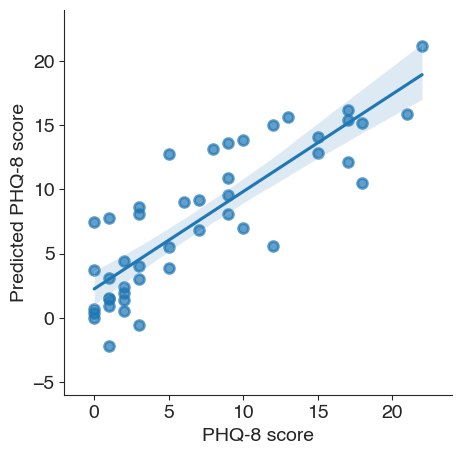

Test 1: MAE = 2.59, RMSE = 3.43, R2 = 0.71


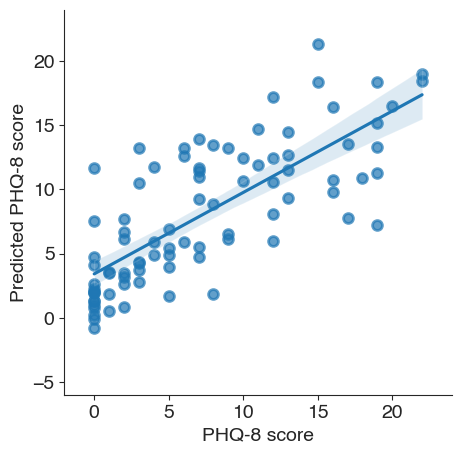

Test 2: MAE = 3.29, RMSE = 4.28, R2 = 0.56


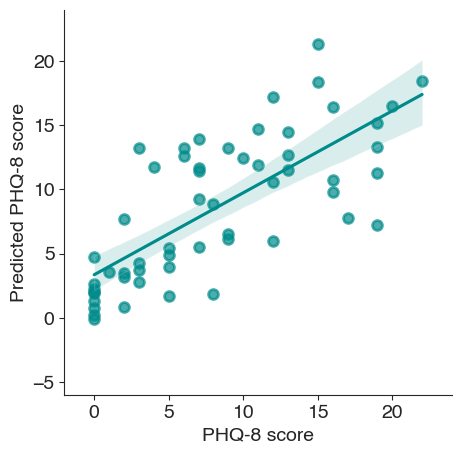

Test 2 E-DAIC: MAE = 3.45, RMSE = 4.43, R2 = 0.52


In [8]:
for split in ["Training", "Test 1", "Test 2", "Test 2 E-DAIC"]:
    wh_split = all_df["split_edaic" if split == "Test 2 E-DAIC" else "split"] == split
    x = all_df["Depression_severity"][wh_split]
    y = all_mdl["Full"]["Y_pred"][wh_split]
    
    plt.figure(figsize=(5, 5))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
    sns.scatterplot(x=x, y=y, s=50, alpha=0.7, legend=False, color="darkcyan" if split == "Test 2 E-DAIC" else "#1F77B4", edgecolors="Face", linewidths=2)
    sns.regplot(x=x, y=y, scatter=False, seed=42, color="darkcyan" if split == "Test 2 E-DAIC" else "#1F77B4")
    sns.despine()
    plt.xlim([-2, 24])
    plt.ylim([-6, 24])
    plt.xlabel("PHQ-8 score", fontsize=14)
    plt.ylabel("Predicted PHQ-8 score", fontsize=14)
    plt.xticks(range(0, 25, 5), fontsize=14)
    plt.yticks(range(-5, 25, 5), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_PHQ-8_vs_Predicted_PHQ-8_{split.replace(" ", "_")}_med42.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}: MAE = {all_mdl["Full"]["metrics"][split]["mae"]:.2f}, RMSE = {all_mdl["Full"]["metrics"][split]["rmse"]:.2f}, R2 = {all_mdl["Full"]["metrics"][split]["r2"]:.2f}")